In [11]:
!pip install tf-keras-vis

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
  Using cached tensorflow_estimator-1.14.0-py2.py3-none-any.whl (488 kB)
  Using cached tensorboard-1.14.0-py3-none-any.whl (3.1 MB)
ERROR: tensorflow-gpu 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 1.14.0 which is incompatible.
ERROR: tensorflow-gpu 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 1.14.0 which is incompatible.
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0


In [1]:
import sys
sys.path.append('..')
from defacing.helpers.utils import load_vol
from defacing.dataloaders.inference_dataloader import DataGeneratoronFly
from defacing.models.modelN import Submodel, relu6

import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf

In [66]:
root_path = '/home/pi/weights/'
mode = 'sagittal'

In [67]:
#from keras.utils.generic_utils import CustomObjectScope
from matplotlib import cm
import os
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize


def get_cam(volume, mode='axial'):
    
    dataloader_params = {
            "conform_size": (64, 64, 64),
            "conform_zoom": (4., 4., 4.), 
            "nchannels": 1, 
            "nruns": 8,
            "nsamples": 20,
            "save": False, 
            "transform": None
        }
    
    datagenerator = DataGeneratoronFly(**dataloader_params)
    slices = datagenerator.get_data(volume)
    slices = np.transpose(np.array(slices),axes=[1, 0, 2, 3, 4])
    ds = {}
    ds['axial'] = slices[0]
    ds['coronal'] = slices[1]
    ds['sagittal'] = slices[2]
    
    model = Submodel(input_shape=(64, 64),
                    name=mode,
                    weights=mode,
                    root_path=root_path,
                    include_top=True,
                    trainable=False)

    score = np.squeeze(model.predict(ds[mode][0][None,...]))
    print(score)
    
    def model_modifier(m):
        m.layers[-1].activation = tf.keras.activations.linear

    # Create Gradcam object
    gradcam = Gradcam(model, model_modifier)

    # Generate heatmap with GradCAM
    cam = gradcam(lambda x: x, ds[mode])
    cam = normalize(cam)
    return ds[mode], cam

In [68]:
faced_path = '../sample_vols/faced/example1.nii.gz'
defaced_path = '../sample_vols/defaced/example1.nii.gz'

0.9999007


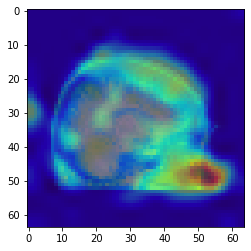

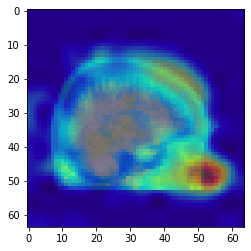

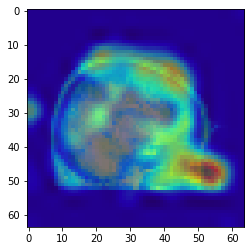

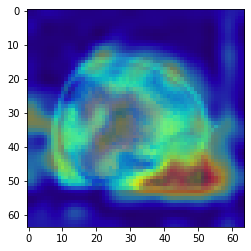

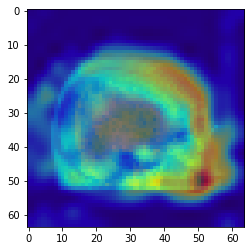

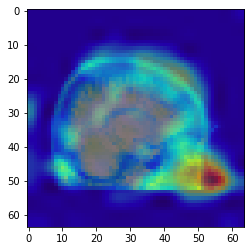

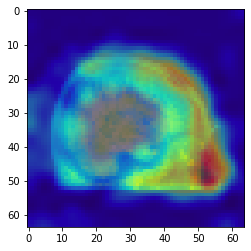

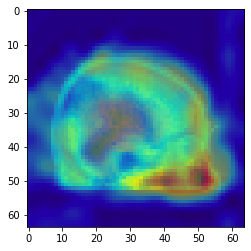

In [72]:
volume, _, _ = load_vol(faced_path)
imgs, cam = get_cam(volume, 'axial')
for i in range(cam.shape[0]):
    plt.imshow(np.rot90(imgs[i,:,:,0], 2))
    plt.imshow(np.rot90(cam[i],2), cmap='jet', alpha=0.5)
    plt.show()

3.3046683e-05


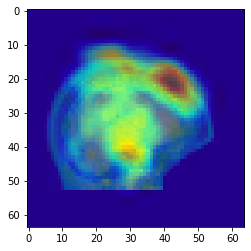

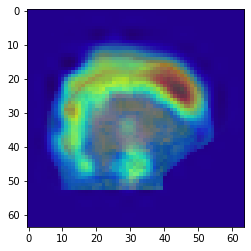

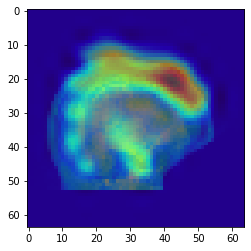

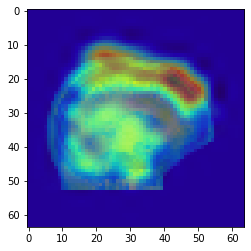

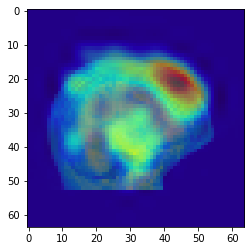

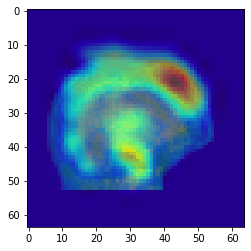

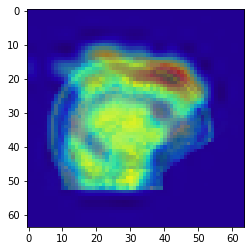

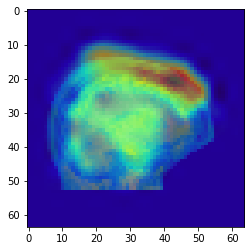

In [73]:
volume, _, _ = load_vol(defaced_path)
imgs, cam = get_cam(volume, 'axial')
for i in range(cam.shape[0]):
    plt.imshow(np.rot90(imgs[i,:,:,0], 2))
    plt.imshow(np.rot90(cam[i],2), cmap='jet', alpha=0.5)
    plt.show()